# Simulated Annealing

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using simulated annealing

__SIMULATED-ANNEALING__(_source_ , _destination_ , _schedule_ , _num of iterations_ ) __returns__ a route  
&emsp;_current_ &larr; random-route between _source_ and _destination_  
&emsp;__for__ _num of iterations_ __do__    
&emsp;&emsp; _T_ &larr; _schedule(t)_  
&emsp;&emsp; _neighbors_ &larr; _current_.NEIGHBOURS  
&emsp;&emsp; _next_ &larr; randomly choose one state from _neighbors_  
&emsp;&emsp; _$\Delta$_ _E_ &larr; _next_._COST_ - _current_._COST_  
&emsp;&emsp; __if__ _$\Delta$_ _E_ &lt; 0 __then__ _current_ &larr; _next_    
&emsp;&emsp; __else__ _current_ &larr; _next_ only with probability of ${e}^{-\frac{\Delta E}{T}}$  
&emsp;__endfor__  
&emsp; _route_ &larr; _current_  
&emsp; __return__ _route_

In [11]:
import osmnx as ox
import numpy as np
import time, sys, itertools
from collections import deque
from tqdm import tqdm
from utilities import *

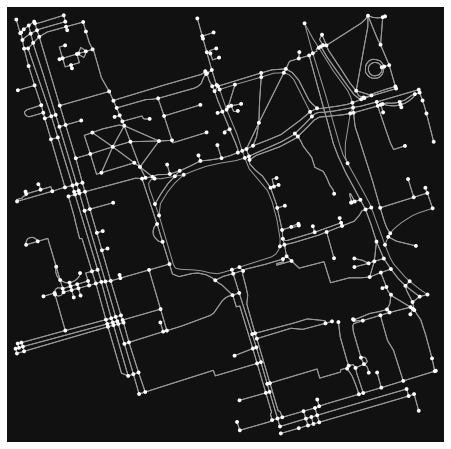

In [12]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

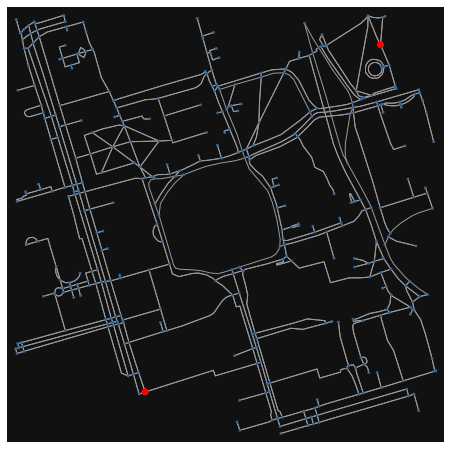

In [13]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [14]:
draw_map(G, highlight = highlighted)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [15]:
%%capture
source(Node)

We need to generate a random path from source and destination to be the starting state in simulated annealing. The following algorithm is just a variant of the typical graph search but instead of choosing the node to be expanded based on a certain policy like bfs/dfs, we just choose the node randomly from the frontier.

In [16]:
source(randomized_search)

The default of the schedule function is that the initial temperature is 20 and it gets terminated after 100 unit time.

In [17]:
source(exp_schedule)

In [18]:
schedule = exp_schedule(200, 0.05, 10000)

This will take about 10 minutes to run, because generating children for a route is a bit computationally expensive.

In [21]:
num_of_iterations = 100

In [20]:
%%time
states = []
current = randomized_search(G, 55808290, 389677909)

# 
for t in tqdm(range(num_of_iterations)):
    T = schedule(t)
    states.append(cost(G, current))
    
    # generate 5 more paths to choose from
    neighbors = [*itertools.islice(children_route(G, current), 100)]
    next_choice = random.choice(neighbors)
    
    delta_e = cost(G, next_choice) - cost(G, current)  
    if delta_e < 0 or probability(np.exp(-1 * delta_e/T)):
        current = next_choice
        
    print(cost(G, current))
    
route = current

  1%|          | 1/120 [00:07<14:24,  7.26s/it]

1143.7269999999999


  2%|▏         | 2/120 [00:14<14:23,  7.31s/it]

1134.147


  2%|▎         | 3/120 [00:25<16:26,  8.43s/it]

1134.147


  3%|▎         | 4/120 [00:36<17:43,  9.17s/it]

1108.2939999999999


  4%|▍         | 5/120 [00:44<17:00,  8.87s/it]

1108.2939999999999


  5%|▌         | 6/120 [00:52<16:05,  8.47s/it]

913.0679999999999


  6%|▌         | 7/120 [01:04<17:46,  9.44s/it]

943.1289999999999


  7%|▋         | 8/120 [01:10<16:03,  8.60s/it]

952.0079999999998


  8%|▊         | 9/120 [01:18<15:33,  8.41s/it]

851.205


  8%|▊         | 10/120 [01:28<16:26,  8.97s/it]

851.205


  9%|▉         | 11/120 [01:39<16:59,  9.35s/it]

949.7299999999999


 10%|█         | 12/120 [01:47<16:18,  9.06s/it]

949.7299999999999


 11%|█         | 13/120 [01:55<15:42,  8.81s/it]

914.255


 12%|█▏        | 14/120 [02:02<14:26,  8.18s/it]

937.0870000000001


 12%|█▎        | 15/120 [02:10<14:25,  8.24s/it]

937.0870000000001


 13%|█▎        | 16/120 [02:19<14:22,  8.29s/it]

937.0870000000001


 14%|█▍        | 17/120 [02:27<14:16,  8.31s/it]

946.196


 15%|█▌        | 18/120 [02:36<14:17,  8.40s/it]

946.196


 16%|█▌        | 19/120 [02:44<14:09,  8.41s/it]

943.3190000000001


 17%|█▋        | 20/120 [03:00<17:55, 10.76s/it]

949.445


 18%|█▊        | 21/120 [03:18<21:05, 12.78s/it]

949.445


 18%|█▊        | 22/120 [03:34<22:40, 13.88s/it]

887.18


 19%|█▉        | 23/120 [03:42<19:27, 12.04s/it]

851.205


 20%|██        | 24/120 [03:52<18:07, 11.33s/it]

851.205


 21%|██        | 25/120 [04:02<17:27, 11.03s/it]

851.205


 22%|██▏       | 26/120 [04:13<17:06, 10.92s/it]

851.205


 22%|██▎       | 27/120 [04:23<16:25, 10.59s/it]

851.205


 23%|██▎       | 28/120 [04:32<15:52, 10.35s/it]

913.0679999999999


 24%|██▍       | 29/120 [04:44<16:16, 10.73s/it]

888.0189999999999


 25%|██▌       | 30/120 [04:51<14:20,  9.56s/it]

888.0189999999999


 26%|██▌       | 31/120 [04:58<13:01,  8.79s/it]

906.043


 27%|██▋       | 32/120 [05:05<12:14,  8.35s/it]

906.043


 28%|██▊       | 33/120 [05:12<11:40,  8.05s/it]

922.5149999999999


 28%|██▊       | 34/120 [05:20<11:05,  7.74s/it]

922.5149999999999


 29%|██▉       | 35/120 [05:27<10:42,  7.56s/it]

922.5149999999999


 30%|███       | 36/120 [05:34<10:33,  7.54s/it]

918.9780000000001


 31%|███       | 37/120 [05:42<10:46,  7.78s/it]

918.9780000000001


 32%|███▏      | 38/120 [05:51<10:56,  8.01s/it]

918.9780000000001


 32%|███▎      | 39/120 [06:00<11:01,  8.17s/it]

917.154


 33%|███▎      | 40/120 [06:07<10:29,  7.87s/it]

917.154


 34%|███▍      | 41/120 [06:14<10:03,  7.63s/it]

917.154


 35%|███▌      | 42/120 [06:21<09:42,  7.46s/it]

917.154


 36%|███▌      | 43/120 [06:28<09:26,  7.36s/it]

887.18


 37%|███▋      | 44/120 [06:36<09:32,  7.54s/it]

887.18


 38%|███▊      | 45/120 [06:44<09:26,  7.56s/it]

887.18


 38%|███▊      | 46/120 [06:52<09:29,  7.69s/it]

887.18


 39%|███▉      | 47/120 [06:59<09:25,  7.74s/it]

887.18


 40%|████      | 48/120 [07:07<09:18,  7.75s/it]

887.18


 41%|████      | 49/120 [07:15<09:06,  7.70s/it]

887.18


 42%|████▏     | 50/120 [07:22<08:53,  7.63s/it]

887.18


 42%|████▎     | 51/120 [07:30<08:48,  7.66s/it]

887.18


 43%|████▎     | 52/120 [07:38<08:46,  7.74s/it]

887.18


 44%|████▍     | 53/120 [07:46<08:36,  7.71s/it]

887.18


 45%|████▌     | 54/120 [07:53<08:30,  7.73s/it]

887.18


 46%|████▌     | 55/120 [08:01<08:19,  7.68s/it]

887.18


 47%|████▋     | 56/120 [08:08<08:10,  7.66s/it]

887.18


 48%|████▊     | 57/120 [08:16<08:01,  7.64s/it]

887.18


 48%|████▊     | 58/120 [08:24<07:52,  7.62s/it]

887.18


 49%|████▉     | 59/120 [08:31<07:43,  7.60s/it]

887.18


 50%|█████     | 60/120 [08:39<07:39,  7.66s/it]

887.18


 51%|█████     | 61/120 [08:47<07:39,  7.79s/it]

887.18


 52%|█████▏    | 62/120 [08:55<07:35,  7.85s/it]

887.18


 52%|█████▎    | 63/120 [09:03<07:24,  7.80s/it]

887.18


 53%|█████▎    | 64/120 [09:11<07:17,  7.81s/it]

887.18


 54%|█████▍    | 65/120 [09:19<07:11,  7.84s/it]

887.18


 55%|█████▌    | 66/120 [09:26<06:59,  7.76s/it]

887.18


 56%|█████▌    | 67/120 [09:34<06:50,  7.75s/it]

887.18


 57%|█████▋    | 68/120 [09:42<06:42,  7.74s/it]

887.18


 57%|█████▊    | 69/120 [09:49<06:31,  7.67s/it]

887.18


 58%|█████▊    | 70/120 [09:57<06:33,  7.87s/it]

887.18


 59%|█████▉    | 71/120 [10:06<06:32,  8.00s/it]

858.1679999999999


 60%|██████    | 72/120 [10:14<06:23,  7.98s/it]

801.9469999999999


 61%|██████    | 73/120 [10:22<06:16,  8.02s/it]

801.9469999999999


 62%|██████▏   | 74/120 [10:30<06:09,  8.04s/it]

801.9469999999999


 62%|██████▎   | 75/120 [10:38<06:09,  8.22s/it]

801.9469999999999


 63%|██████▎   | 76/120 [10:48<06:21,  8.66s/it]

801.9469999999999


 64%|██████▍   | 77/120 [10:58<06:25,  8.97s/it]

801.9469999999999


 65%|██████▌   | 78/120 [11:08<06:25,  9.19s/it]

801.9469999999999


 66%|██████▌   | 79/120 [11:17<06:24,  9.37s/it]

801.9469999999999


 67%|██████▋   | 80/120 [11:26<06:11,  9.29s/it]

801.9469999999999


 68%|██████▊   | 81/120 [11:35<05:54,  9.09s/it]

801.9469999999999


 68%|██████▊   | 82/120 [11:44<05:41,  8.98s/it]

801.9469999999999


 69%|██████▉   | 83/120 [11:52<05:28,  8.87s/it]

801.9469999999999


 70%|███████   | 84/120 [12:01<05:18,  8.86s/it]

801.9469999999999


 71%|███████   | 85/120 [12:10<05:11,  8.90s/it]

801.9469999999999


 72%|███████▏  | 86/120 [12:19<05:01,  8.88s/it]

801.9469999999999


 72%|███████▎  | 87/120 [12:28<04:50,  8.80s/it]

801.9469999999999


 73%|███████▎  | 88/120 [12:37<04:42,  8.82s/it]

801.9469999999999


 74%|███████▍  | 89/120 [12:45<04:28,  8.66s/it]

801.9469999999999


 75%|███████▌  | 90/120 [12:53<04:14,  8.50s/it]

801.9469999999999


 76%|███████▌  | 91/120 [13:01<04:04,  8.43s/it]

801.9469999999999


 77%|███████▋  | 92/120 [13:10<03:55,  8.41s/it]

801.9469999999999


 78%|███████▊  | 93/120 [13:18<03:48,  8.44s/it]

801.9469999999999


 78%|███████▊  | 94/120 [13:27<03:43,  8.60s/it]

801.9469999999999


 79%|███████▉  | 95/120 [13:37<03:43,  8.95s/it]

801.9469999999999


 80%|████████  | 96/120 [13:47<03:41,  9.25s/it]

801.9469999999999


 81%|████████  | 97/120 [13:56<03:33,  9.28s/it]

801.9469999999999


 82%|████████▏ | 98/120 [14:06<03:25,  9.32s/it]

801.9469999999999


 82%|████████▎ | 99/120 [14:15<03:15,  9.31s/it]

801.9469999999999


 83%|████████▎ | 100/120 [14:24<03:05,  9.29s/it]

801.9469999999999


 84%|████████▍ | 101/120 [14:33<02:55,  9.25s/it]

801.9469999999999


 85%|████████▌ | 102/120 [14:42<02:43,  9.10s/it]

801.9469999999999


 86%|████████▌ | 103/120 [14:51<02:31,  8.92s/it]

801.9469999999999


 87%|████████▋ | 104/120 [14:59<02:20,  8.79s/it]

801.9469999999999


 88%|████████▊ | 105/120 [15:07<02:08,  8.60s/it]

801.9469999999999


 88%|████████▊ | 106/120 [15:15<01:58,  8.48s/it]

801.9469999999999


 89%|████████▉ | 107/120 [15:24<01:51,  8.56s/it]

801.9469999999999


 90%|█████████ | 108/120 [15:33<01:42,  8.57s/it]

801.9469999999999


 91%|█████████ | 109/120 [15:41<01:33,  8.47s/it]

801.9469999999999


 92%|█████████▏| 110/120 [15:49<01:23,  8.40s/it]

801.9469999999999


 92%|█████████▎| 111/120 [15:58<01:15,  8.43s/it]

801.9469999999999


 93%|█████████▎| 112/120 [16:07<01:09,  8.69s/it]

801.9469999999999


 94%|█████████▍| 113/120 [16:17<01:04,  9.17s/it]

801.9469999999999


 95%|█████████▌| 114/120 [16:28<00:57,  9.61s/it]

801.9469999999999


 96%|█████████▌| 115/120 [16:39<00:49,  9.96s/it]

801.9469999999999


 97%|█████████▋| 116/120 [16:49<00:40, 10.13s/it]

801.9469999999999


 98%|█████████▊| 117/120 [16:59<00:29,  9.98s/it]

801.9469999999999


 98%|█████████▊| 118/120 [17:08<00:19,  9.66s/it]

801.9469999999999


 99%|█████████▉| 119/120 [17:16<00:09,  9.31s/it]

801.9469999999999


100%|██████████| 120/120 [17:24<00:00,  8.71s/it]

801.9469999999999
CPU times: user 17min 20s, sys: 2.07 s, total: 17min 22s
Wall time: 17min 24s


In [22]:
cost(G, route)

801.9469999999999

Remember that the optimal cost for the route is 801.4639999999999  

You should get 830-ish as the cost of the route between source and destination without any tuning of the schedule function.

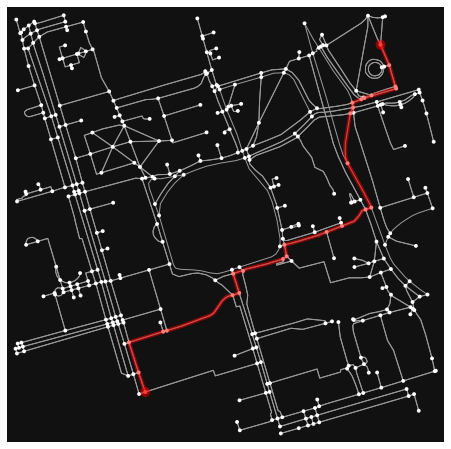

In [23]:
fig, ax = ox.plot_graph_route(G, current)

In [24]:
draw_route(G, route)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

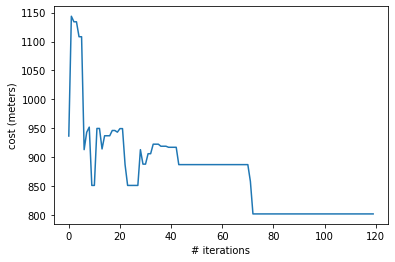

In [26]:
import matplotlib.pyplot as plt
plt.xlabel("# iterations")
plt.ylabel("cost (meters)")
plt.plot(states)
plt.show()